In [96]:
import os
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk

from plotnine import *
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Extracting speeches from local directory

In [ ]:
# Path to the folder containing your Jupyter notebook
notebook_folder = os.getcwd()

# Path to the folder containing the speeches
speeches_folder = os.path.join(notebook_folder, "Speeches105")

In [97]:
def extract_text_from_files(folder_path):
    senator_speeches = {}

    # Regular expression pattern to extract senator names from file names
    senator_name_pattern = re.compile(r'\d+-(\w+)-\w+')

    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if os.path.isfile(file_path) and filename.endswith('.txt'):
            with open(file_path, 'r') as file:
                text = file.read()
                senator_name_match = senator_name_pattern.search(filename)
                if senator_name_match:
                    senator_name = senator_name_match.group(1)
                    # Extract text between <TEXT> and </TEXT> tags
                    text_matches = re.findall(r'<TEXT>(.*?)</TEXT>', text, re.DOTALL)
                    if text_matches:
                        # Combine speeches
                        combined_speech = ' '.join(text_matches)
                        # Append combined speech to the senator's speech or create new entry
                        if senator_name in senator_speeches:
                            senator_speeches[senator_name] += combined_speech
                        else:
                            senator_speeches[senator_name] = combined_speech

    return senator_speeches


# Extract speeches from files
senator_speeches = extract_text_from_files(speeches_folder)


In [99]:
first_few_items = list(senator_speeches.items())[:3]

# Print the first few keys and values
for senator, speech in first_few_items:
    print(f"Senator: {senator}")
    print(f"Speech:{speech[:200]}...")  # Print only the first 200 characters of the speech
    print("\n")

Senator: abraham
Speech:
 Mr. ABRAHAM. Mr. President, during debate on final passage of the Omnibus Appropriations bill, in which the American Competitiveness and Workforce Improvement Act was included as Title IV of Subdivi...


Senator: akaka
Speech:
Mr. AKAKA. Mr. President, I am pleased that the Senate passed H.R. 4110, the Veterans Programs Enhancement Act of 1998. This measure strives to improve the services and benefits provided to our natio...


Senator: allard
Speech:
 Mr. ALLARD. Mr. President, I rise to make a few remarks concerning the Auto Choice Reform Act. I am a co-sponsor of this legislation. 
The Auto Choice Act proposes the development of a `no fault com...




# Similarity Analysis

I will be using cosine similarity to measure how much the speeches compare to each other. The three pre processings methods I will be using:
1. Simple: No punctuation, No stop words, No digits
2. Stemming: No punctuation, No stop words, No digits, Stemmed
3. Lemmatization: No punctuation, No stop words, No digits, Lemmatization

### 1. Simple Pre Processing

In [100]:
stop_words = set(stopwords.words('english'))

def simple_preprocess(text):
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token not in string.punctuation]
    tokens = [token for token in tokens if token not in stop_words]
    tokens = [token for token in tokens if not re.search(r'\d', token)]
    
    preprocessed_text = ' '.join(tokens)
    
    return preprocessed_text

In [101]:
preprocessed_speeches = {}

# Preprocess speeches in the senator_speeches dictionary
for senator, speech in senator_speeches.items():
    preprocessed_speech = simple_preprocess(speech)
    preprocessed_speeches[senator] = preprocessed_speech


In [102]:
first_few_items = list(preprocessed_speeches.items())[:3]

# Print the first few keys and values
for senator, speech in first_few_items:
    print(f"Senator: {senator}")
    print(f"Speech:{speech[:200]}...")  # Print only the first 200 characters of the speech
    print("\n")

Senator: abraham
Speech:mr. abraham mr. president debate final passage omnibus appropriations bill american competitiveness workforce improvement act included title iv subdivision c asked unanimous consent number documents p...


Senator: akaka
Speech:mr. akaka mr. president pleased senate passed h.r veterans programs enhancement act measure strives improve services benefits provided nation 's veterans amending several health education housing bene...


Senator: allard
Speech:mr. allard mr. president rise make remarks concerning auto choice reform act co-sponsor legislation auto choice act proposes development fault compensation system provide option drivers want pay servi...




In [103]:
# Assuming processed_speeches is your dictionary where keys are senator names and values are their preprocessed speeches

# Extract the speech of Senator Biden
biden_speech = preprocessed_speeches['biden']

# Extract preprocessed speeches of all other senators
other_speeches = [speech for senator, speech in preprocessed_speeches.items() if senator != 'biden']

# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the speeches
tfidf_matrix = tfidf_vectorizer.fit_transform([biden_speech] + other_speeches)

# Calculate cosine similarities
cosine_similarities = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:])

In [104]:
senator_names = [senator for senator in preprocessed_speeches.keys() if senator != 'biden']

df_simple = pd.DataFrame({'Senator': senator_names, 'Cosine Similarity': cosine_similarities[0]})
df_simple = df_simple.sort_values(by='Cosine Similarity', ascending=False).reset_index(drop=True)
df_simple

,Senator,Cosine Similarity
0,kyl,0.818854
1,kerry,0.818003
2,lieberman,0.813120
3,roberts,0.812707
4,byrd,0.800467
...,...,...
93,landrieu,0.654313
94,johnson,0.650973
95,frist,0.646929
96,akaka,0.558238


### 2. Stemming

In [105]:
stop_words = set(stopwords.words('english'))

def stemming(text):
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token not in string.punctuation]
    tokens = [token for token in tokens if token not in stop_words]
    tokens = [token for token in tokens if not re.search(r'\d', token)]
    
    stemmer = LancasterStemmer()
    tokens_lemmatized = [stemmer.stem(token) for token in tokens]
    preprocessed_text = ' '.join(tokens_lemmatized)
    
    return preprocessed_text

In [106]:
preprocessed_speeches = {}

# Preprocess speeches in the senator_speeches dictionary
for senator, speech in senator_speeches.items():
    preprocessed_speech = stemming(speech)
    preprocessed_speeches[senator] = preprocessed_speech


In [107]:
first_few_items = list(preprocessed_speeches.items())[:3]

# Print the first few keys and values
for senator, speech in first_few_items:
    print(f"Senator: {senator}")
    print(f"Speech:{speech[:200]}...")  # Print only the first 200 characters of the speech
    print("\n")

Senator: abraham
Speech:mr. abraham mr. presid deb fin pass omnib appropry bil am competit workforc improv act includ titl iv subdivid c ask unanim cons numb docu print record includ two docu receiv admin negoty whos includ ...


Senator: akaka
Speech:mr. akak mr. presid pleas sen pass h.r vet program enh act meas strives improv serv benefit provid nat 's vet amend sev heal educ hous benefit program within depart vet affair espec pleas meas contain...


Senator: allard
Speech:mr. allard mr. presid ris mak remark concern auto cho reform act co-sponsor legisl auto cho act propos develop fault compens system provid opt driv want pay serv want us legisl would allow recovery ec...




In [108]:
# Assuming processed_speeches is your dictionary where keys are senator names and values are their preprocessed speeches

# Extract the speech of Senator Biden
biden_speech = preprocessed_speeches['biden']

# Extract preprocessed speeches of all other senators
other_speeches = [speech for senator, speech in preprocessed_speeches.items() if senator != 'biden']

# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the speeches
tfidf_matrix = tfidf_vectorizer.fit_transform([biden_speech] + other_speeches)

# Calculate cosine similarities
cosine_similarities = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:])

In [109]:
senator_names = [senator for senator in preprocessed_speeches.keys() if senator != 'biden']

df_stemming = pd.DataFrame({'Senator': senator_names, 'Cosine Similarity': cosine_similarities[0]})
df_stemming = df_stemming.sort_values(by='Cosine Similarity', ascending=False).reset_index(drop=True)
df_stemming

,Senator,Cosine Similarity
0,lieberman,0.863413
1,kerry,0.862399
2,kyl,0.861533
3,roberts,0.859547
4,craig,0.853919
...,...,...
93,ford,0.727871
94,gramm,0.725771
95,stevens,0.705736
96,akaka,0.665227


### 3. Lemmatization

In [110]:
stop_words = set(stopwords.words('english'))

def lemmatization(text):
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token not in string.punctuation]
    tokens = [token for token in tokens if token not in stop_words]
    tokens = [token for token in tokens if not re.search(r'\d', token)]
    
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    preprocessed_text = ' '.join(tokens)
    
    return preprocessed_text

In [111]:
preprocessed_speeches = {}

# Preprocess speeches in the senator_speeches dictionary
for senator, speech in senator_speeches.items():
    preprocessed_speech = lemmatization(speech)
    preprocessed_speeches[senator] = preprocessed_speech


In [112]:
first_few_items = list(preprocessed_speeches.items())[:3]

# Print the first few keys and values
for senator, speech in first_few_items:
    print(f"Senator: {senator}")
    print(f"Speech:\n{speech[:200]}...")  # Print only the first 200 characters of the speech
    print("\n")

Senator: abraham
Speech:
mr. abraham mr. president debate final passage omnibus appropriation bill american competitiveness workforce improvement act included title iv subdivision c asked unanimous consent number document pri...


Senator: akaka
Speech:
mr. akaka mr. president pleased senate passed h.r veteran program enhancement act measure strives improve service benefit provided nation 's veteran amending several health education housing benefit p...


Senator: allard
Speech:
mr. allard mr. president rise make remark concerning auto choice reform act co-sponsor legislation auto choice act proposes development fault compensation system provide option driver want pay service...




In [113]:
# Assuming processed_speeches is your dictionary where keys are senator names and values are their preprocessed speeches

# Extract the speech of Senator Biden
biden_speech = preprocessed_speeches['biden']

# Extract preprocessed speeches of all other senators
other_speeches = [speech for senator, speech in preprocessed_speeches.items() if senator != 'biden']

# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the speeches
tfidf_matrix = tfidf_vectorizer.fit_transform([biden_speech] + other_speeches)

# Calculate cosine similarities
cosine_similarities = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:])

In [114]:
senator_names = [senator for senator in preprocessed_speeches.keys() if senator != 'biden']

df_lemming = pd.DataFrame({'Senator': senator_names, 'Cosine Similarity': cosine_similarities[0]})
df_lemming = df_lemming.sort_values(by='Cosine Similarity', ascending=False).reset_index(drop=True)
df_lemming

,Senator,Cosine Similarity
0,roberts,0.830557
1,kerry,0.826970
2,kyl,0.826930
3,lieberman,0.823923
4,byrd,0.814742
...,...,...
93,johnson,0.675891
94,frist,0.667077
95,stevens,0.661122
96,akaka,0.588192


### Similarities amongst Senators

In [115]:
senator_data = pd.read_csv('sen105kh_fix.csv',sep=';')

In [116]:
senator_data

,cong,lname,stateab,lstate,id,dist,party
0,105,sessions,al,ALABAMA,49700,0,200
1,105,shelby,al,ALABAMA,94659,0,200
2,105,murkowski,ak,ALASKA,14907,0,200
3,105,stevens,ak,ALASKA,12109,0,200
4,105,kyl,az,ARIZONA,15429,0,200
...,...,...,...,...,...,...,...
95,105,rockefeller,wv,WEST VI,14922,0,100
96,105,feingold,wi,WISCONS,49309,0,100
97,105,kohl,wi,WISCONS,15703,0,100
98,105,enzi,wy,WYOMING,49706,0,200


In [117]:
# Assuming df_stemming, df_lemming, and df_senator_info are your dataframes for stemming, lemming, and senator information, respectively

# Merge stemming and lemming dataframes on Senator name
df_merged = pd.merge(df_stemming, df_lemming, on='Senator', suffixes=('(Stemming)', '(Lemming)'))
df_merged = pd.merge(df_merged, df_simple, on='Senator', suffixes=('_Stemming', '_Simple'))


# Merge the merged dataframe with senator information dataframe on Senator name
df_final = pd.merge(senator_data,df_merged, left_on='lname', right_on='Senator')

# Drop redundant columns and rename columns if necessary
df_final = df_final.drop(columns=['lname', 'stateab', 'id','dist','cong'])  # Drop redundant columns
df_final = df_final.rename(columns={'party': 'Party','lstate':'State'})  # Rename 'party' column to 'Party'
df_final = df_final.rename(columns={'Cosine Similarity(Stemming)': 'CS Stemming'
                                    ,'Cosine Similarity(Lemming)':'CS Lemmatization'
                                    ,'Cosine Similarity':'CS Simple'})  # Rename 'party' column to 'Party'



In [118]:
df_final

,State,Party,Senator,CS Stemming,CS Lemmatization,CS Simple
0,ALABAMA,200,sessions,0.828820,0.791619,0.775229
1,ALABAMA,200,shelby,0.775539,0.729691,0.711033
2,ALASKA,200,murkowski,0.806029,0.754953,0.739032
3,ALASKA,200,stevens,0.705736,0.661122,0.655088
4,ARIZONA,200,kyl,0.861533,0.826930,0.818854
...,...,...,...,...,...,...
94,WEST VI,100,rockefeller,0.746397,0.683354,0.665716
95,WISCONS,100,feingold,0.843054,0.802686,0.788129
96,WISCONS,100,kohl,0.773304,0.720376,0.705409
97,WYOMING,200,enzi,0.789717,0.743915,0.728190


In [136]:
top_5_simple = df_final.sort_values(by='CS Simple', ascending=False).head(5)
top_5_simple[['Party','State','Senator','CS Simple']]

,Party,State,Senator,CS Simple
4,200,ARIZONA,kyl,0.818854
40,100,MASSACH,kerry,0.818003
13,100,CONNECT,lieberman,0.813120
30,200,KANSAS,roberts,0.812707
93,100,WEST VI,byrd,0.800467


In [119]:
top_5_stemming = df_final.sort_values(by='CS Stemming', ascending=False).head(5)
top_5_stemming[['Party','State','Senator','CS Stemming']]

,Party,State,Senator,CS Stemming
13,100,CONNECT,lieberman,0.863413
40,100,MASSACH,kerry,0.862399
4,200,ARIZONA,kyl,0.861533
30,200,KANSAS,roberts,0.859547
21,200,IDAHO,craig,0.853919


In [120]:
top_5_lemming = df_final.sort_values(by='CS Lemmatization', ascending=False).head(5)
top_5_lemming[['Party','State','Senator','CS Lemmatization']]

,Party,State,Senator,CS Lemmatization
30,200,KANSAS,roberts,0.830557
40,100,MASSACH,kerry,0.826970
4,200,ARIZONA,kyl,0.826930
13,100,CONNECT,lieberman,0.823923
93,100,WEST VI,byrd,0.814742


##### For simple preprocess, we get 3 democrats and 2 republican senators, however top senator is republican.
##### For stemming preprocess, we get 2 democrats and 3 republican senators, however top senator is democarat.
##### For lemmatization preprocess, we get 3 democrats and 2 republican senators, however top senator is republican.

# Visualization

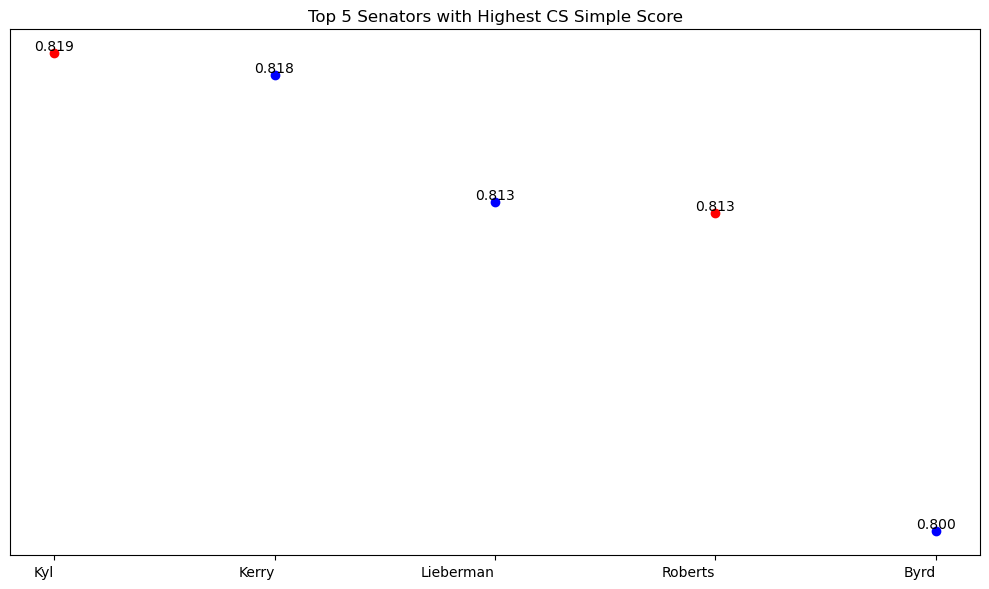

In [122]:
import pandas as pd
import matplotlib.pyplot as plt

# Select the top 5 senators based on CS Simple score
top_5_senators_simple = df_final.nlargest(5, 'CS Simple')
top_5_senators_simple["Senator"] = top_5_senators_simple["Senator"].str.capitalize() 

# Define colors for each party
party_colors = {'100': 'blue', '200': 'red'}

# Plot the scatter plot
plt.figure(figsize=(10, 6))
for index, senator in top_5_senators_simple.iterrows():
    plt.scatter(senator['Senator'], senator['CS Simple'], color=party_colors.get(str(senator['Party']), 'gray'))
    plt.text(senator['Senator'], senator['CS Simple'], f'{senator["CS Simple"]:.3f}', ha='center', va='bottom')

# Customize plot
plt.title('Top 5 Senators with Highest CS Simple Score')
plt.xticks(rotation=0, ha='right')  # Rotate x-axis ticks to 0 degrees
plt.ylabel('CS Simple Score')
plt.gca().axes.get_yaxis().set_visible(False)  # Hide y-axis
plt.tight_layout()
plt.show()


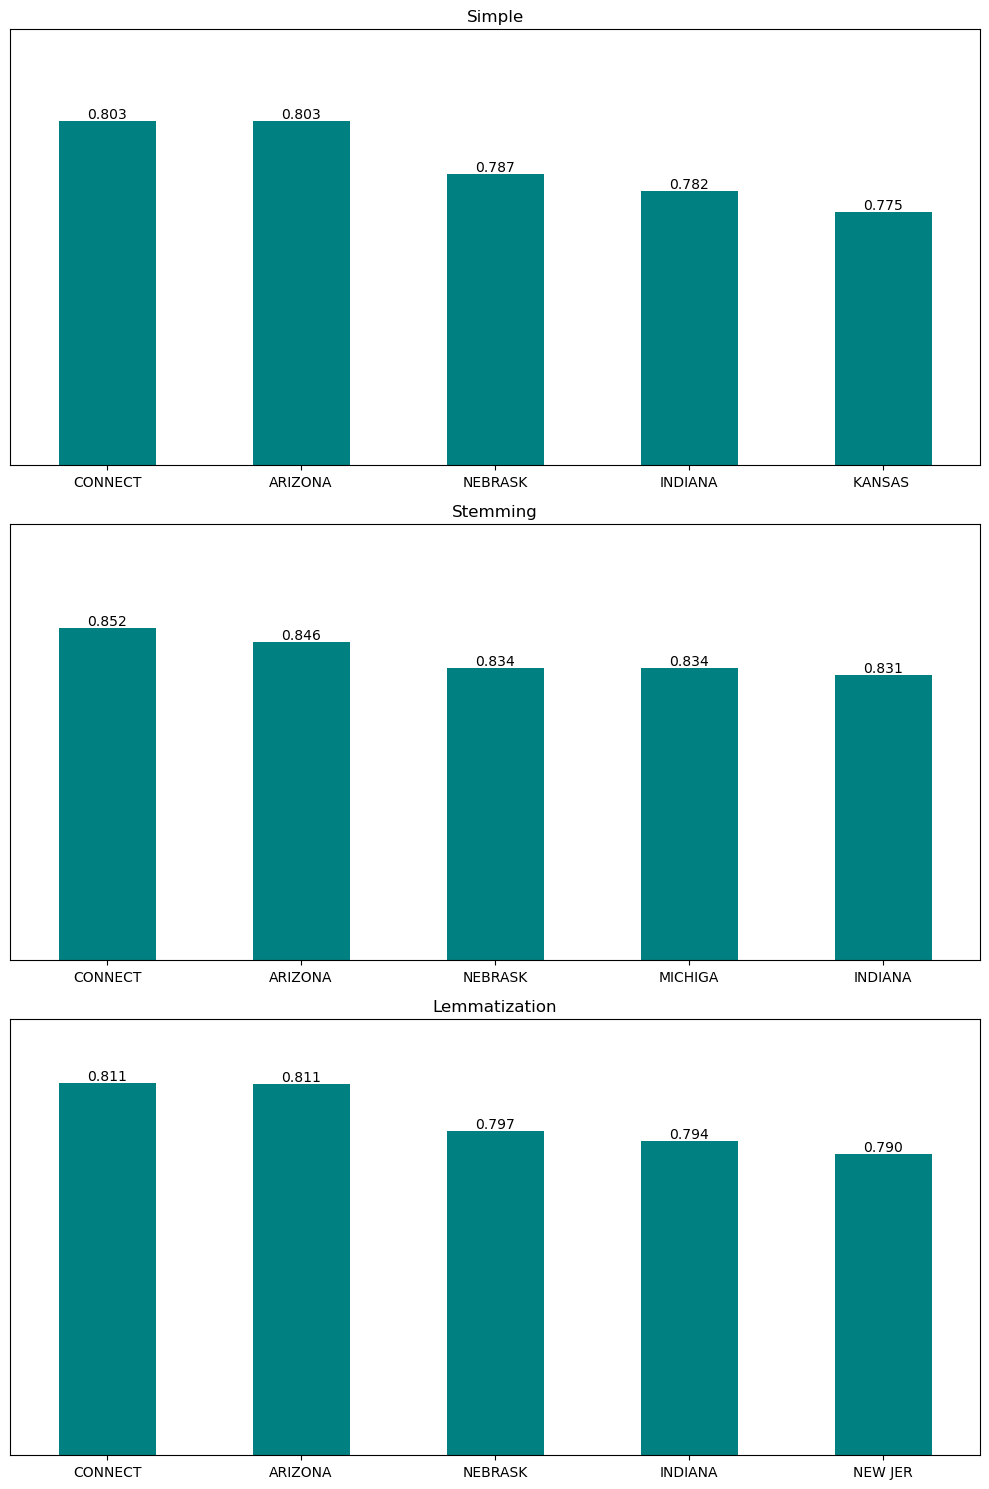

In [123]:
import pandas as pd
import matplotlib.pyplot as plt

# Separate DataFrames for CS Lemmatization, CS Simple, and CS Stemming
df_cs_lemmatization = df_final[['State', 'CS Lemmatization']]
df_cs_simple = df_final[['State', 'CS Simple']]
df_cs_stemming = df_final[['State', 'CS Stemming']]

# Compute the mean scores for each state
mean_cs_lemmatization = df_cs_lemmatization.groupby('State').mean()
mean_cs_simple = df_cs_simple.groupby('State').mean()
mean_cs_stemming = df_cs_stemming.groupby('State').mean()

# Select the top 5 states based on mean scores
top_5_states_lemmatization = mean_cs_lemmatization.nlargest(5, 'CS Lemmatization')
top_5_states_simple = mean_cs_simple.nlargest(5, 'CS Simple')
top_5_states_stemming = mean_cs_stemming.nlargest(5, 'CS Stemming')

# Plotting subplots
fig, axs = plt.subplots(3, figsize=(10, 15))

# Plot bar graph for CS Simple
top_5_states_simple.plot(kind='bar', ax=axs[0], color='#008080', legend=False)
axs[0].set_title('Simple')
axs[0].set_ylim(0.7, 0.83)  # Set y-axis limits
axs[0].tick_params(axis='x', rotation=0)  # Rotate x-axis tick labels
axs[0].tick_params(axis='y', which='both', left=False, labelleft=False)  # Hide y-axis tick labels
axs[0].set_xlabel('')  # Remove x-axis title

# Plot bar graph for CS Stemming
top_5_states_stemming.plot(kind='bar', ax=axs[1], color='#008080', legend=False)
axs[1].set_title('Stemming')
axs[1].set_ylim(0.7, 0.9)  # Set y-axis limits
axs[1].tick_params(axis='x', rotation=0)  # Rotate x-axis tick labels
axs[1].tick_params(axis='y', which='both', left=False, labelleft=False)  # Hide y-axis tick labels
axs[1].set_xlabel('')  # Remove x-axis title

# Plot bar graph for CS Lemmatization
top_5_states_lemmatization.plot(kind='bar', ax=axs[2], color='#008080', legend=False)
axs[2].set_title('Lemmatization')
axs[2].set_ylim(0.7, 0.83)  # Set y-axis limits
axs[2].tick_params(axis='x', rotation=0)  # Rotate x-axis tick labels
axs[2].tick_params(axis='y', which='both', left=False, labelleft=False)  # Hide y-axis tick labels
axs[2].set_xlabel('')  # Remove x-axis title

# Format data labels to display values with three decimal points
for ax in axs:
    for rect in ax.patches:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height, f'{height:.3f}', ha='center', va='bottom')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


# Prediction

In [124]:
# Creating a prediction dataframe

df = pd.DataFrame(list(senator_speeches.items()), columns=['Senator', 'Speech'])
data = pd.merge(df, senator_data, left_on='Senator', right_on='lname')
data = data.drop(columns=['lname', 'stateab','lstate', 'id','dist','cong'])  # Drop redundant columns
data

,Senator,Speech,party
0,abraham,"\n Mr. ABRAHAM. Mr. President, during debate o...",200
1,akaka,"\nMr. AKAKA. Mr. President, I am pleased that ...",100
2,allard,"\n Mr. ALLARD. Mr. President, I rise to make a...",200
3,ashcroft,"\nMr. ASHCROFT. Mr. President, the Senate is n...",200
4,baucus,\nMr. BAUCUS. I understand that the House has ...,100
...,...,...,...
95,thurmond,"\nMr. THURMOND. Mr. President, as the Senate c...",200
96,torricelli,\nMr. TORRICELLI. Mr. President I thank Senato...,100
97,warner,"\nMr. WARNER. During the past two weeks, the S...",200
98,wellstone,"\nMr. WELLSTONE. Mr. President, today, I would...",100


In [125]:
speech_train, speech_test, party_train, party_test = train_test_split(data['Speech'], data['party'], test_size=0.2
                                                                      , random_state=42, stratify=data['party'])

## Prediction with Simple Preprocessing

In [126]:
# Define the pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2),preprocessor=simple_preprocess)),
    ('classifier', MultinomialNB(alpha = 0.0001))  
])

In [127]:
pipeline.fit(speech_train, party_train)
predictions = pipeline.predict(speech_test)

In [128]:
print (classification_report(party_test,  predictions))

              precision    recall  f1-score   support

         100       1.00      0.67      0.80         9
         200       0.79      1.00      0.88        11

    accuracy                           0.85        20
   macro avg       0.89      0.83      0.84        20
weighted avg       0.88      0.85      0.84        20



## Prediction with Stemming Preprocessing

In [133]:
# Define the pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2),preprocessor=stemming)),
    ('classifier', MultinomialNB(alpha = 0.0001))  
])

In [134]:
pipeline.fit(speech_train, party_train)
predictions = pipeline.predict(speech_test)

In [135]:
print (classification_report(party_test,  predictions))

              precision    recall  f1-score   support

         100       0.86      0.67      0.75         9
         200       0.77      0.91      0.83        11

    accuracy                           0.80        20
   macro avg       0.81      0.79      0.79        20
weighted avg       0.81      0.80      0.80        20

